# SpecParam

This notebook measures aperiodic activity using the 'spectral parameterization' algorithm.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from neurodsp.sim import sim_powerlaw, sim_synaptic_current, sim_combined, sim_peak_oscillation
from neurodsp.spectral import compute_spectrum
from neurodsp.utils import set_random_seed

from fooof import FOOOF
from fooof.plts import plot_spectrum, plot_spectra

/var/folders/59/8y2d5r257c77vzymnqs47x080000gn/T/ipykernel_8782/1584007569.py:8: DeprecationWarning: 
The `fooof` package is being deprecated and replaced by the `specparam` (spectral parameterization) package.
This version of `fooof` (1.1) is fully functional, but will not be further updated.
New projects are recommended to update to using `specparam` (see Changelog for details).
  from fooof import FOOOF


In [2]:
# Import custom code
import sys; from pathlib import Path
sys.path.append(str(Path('..').resolve()))

from apm.io import APMDB
from apm.run import run_sims, run_sims_load
from apm.methods import specparam
from apm.methods.settings import SPECPARAM_PARAMS, SPECPARAM_PARAMS_KNEE, FIT_F_RANGE, FIT_F_RANGE_LONG
from apm.plts.sims import plot_sims, plot_ap_sims, plot_pe_sims
from apm.plts.settings import EXT, COLORS
from apm.sim.settings import (FS, EXP, EXPS, KNEES, FREQS, POWERS, BWS, N_SIMS,
                              SIM_PARAMS_AP, SIM_PARAMS_COMB, SIM_PARAMS_KNEE, SIM_PARAMS_PEAK)
from apm.sim.examples import SIG_AP, SIG_KN, SIG_OSC, SIG_COMB, SIG_PEAK
from apm.sim.sim import sim_combined_peak

In [3]:
import seaborn as sns
sns.set_context('talk')

## Settings

In [4]:
# Notebook settings
SAVE_FIG = False

In [5]:
# Plot settings
PSD_PLT_KWARGS = {
    'plt_log' : True,
}

In [6]:
# Settings for saving figures
SAVE_FIG = True
EXT = '.pdf'
FIGPATH = APMDB().figs_path / '22_specparam'

In [7]:
# Settings for loading simulations
SIMPATH = APMDB().sims_path / 'time_series'

In [8]:
# Set the random seed
set_random_seed(111)

### SpecParam Settings

In [9]:
# Check the SpecParam settings
SPECPARAM_PARAMS

{'fs': 500, 'f_range': (1, 50), 'min_peak_height': 0.05}

In [10]:
# Check the SpecParam settings - knee
SPECPARAM_PARAMS_KNEE

{'fs': 500,
 'f_range': (1, 100),
 'min_peak_height': 0.05,
 'aperiodic_mode': 'knee'}

### Spectral Parameterization on Example Signals

In [11]:
# Define a spectral model 
fm = FOOOF(min_peak_height=0.2, verbose=False)
fm_kn = FOOOF(min_peak_height=0.2, aperiodic_mode='knee', verbose=False)

#### Powerlaw Signal

In [12]:
# Compute the full power spectrum
freqs, powers = compute_spectrum(SIG_AP, FS, noverlap=0.5*FS, f_range=FIT_F_RANGE)

In [13]:
# Fit the spectral model
fm.fit(freqs, powers)

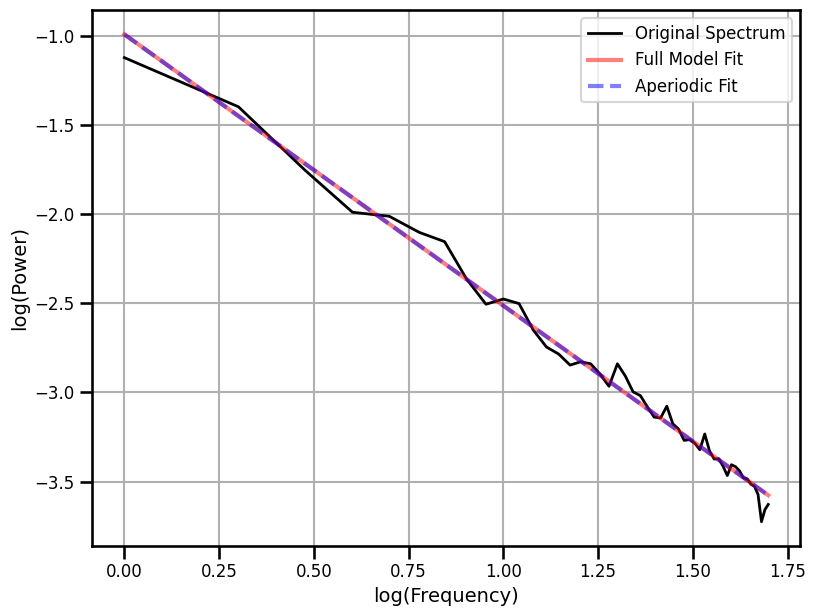

In [14]:
# Visualize 
fm.plot(**PSD_PLT_KWARGS,
        save_fig=SAVE_FIG, file_name='sp_example_ap' + EXT, file_path=FIGPATH)

In [15]:
# Check the calculated value against ground truth
print('Measured Exponent:\t {:1.4f}'.format(fm.get_params('aperiodic', 'exponent')))
print('Expected Exponent:\t {:1.4f}'.format(EXP))

Measured Exponent:	 1.5209
Expected Exponent:	 -1.5000


#### Combined Signal

In [16]:
# Compute the full power spectrum
freqs, powers = compute_spectrum(SIG_COMB, FS, noverlap=0.5*FS, f_range=FIT_F_RANGE)

In [17]:
# Fit the spectral model
fm.fit(freqs, powers)

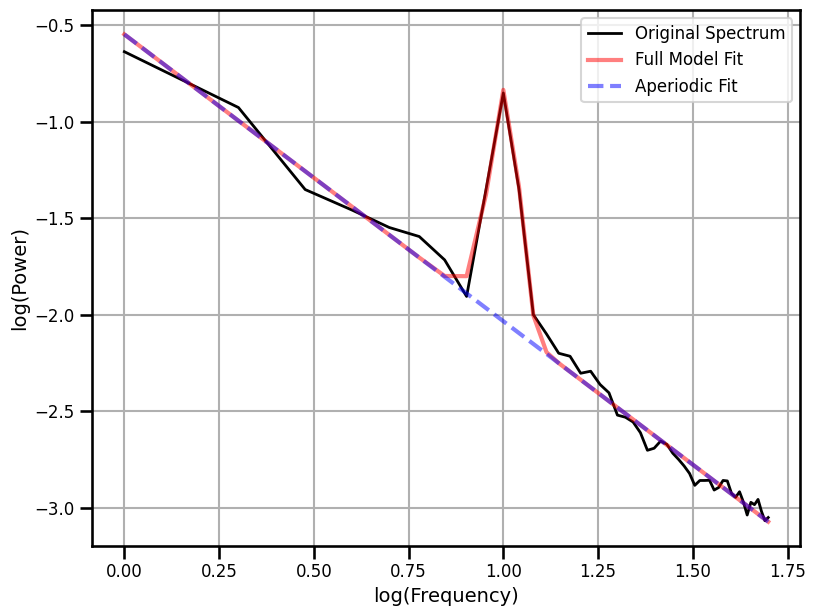

In [18]:
# Visualize 
fm.plot(**PSD_PLT_KWARGS,
        save_fig=SAVE_FIG, file_name='sp_example_pe' + EXT, file_path=FIGPATH)

In [19]:
# Check the calculated value against ground truth
print('Measured Exponent:\t {:1.4f}'.format(fm.get_params('aperiodic', 'exponent')))
print('Expected Exponent:\t {:1.4f}'.format(EXP))

Measured Exponent:	 1.4860
Expected Exponent:	 -1.5000


#### Knee Signal

In [20]:
# Compute the full power spectrum
freqs, powers = compute_spectrum(SIG_KN, FS, noverlap=0.5*FS, f_range=FIT_F_RANGE_LONG)

In [21]:
# Fit the spectral model
fm.fit(freqs, powers)
fm_kn.fit(freqs, powers)

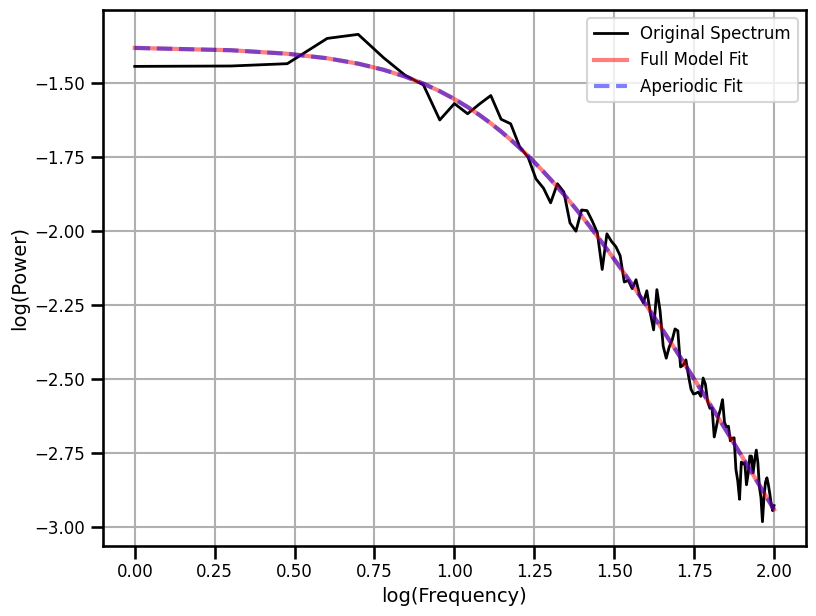

In [22]:
# Visualize 
fm_kn.plot(**PSD_PLT_KWARGS,
           save_fig=SAVE_FIG, file_name='sp_example_knee' + EXT, file_path=FIGPATH)

In [23]:
# Check the calculated value against ground truth
print('Measured Exponent (fixed):\t {:1.4f}'.format(fm.get_params('aperiodic', 'exponent')))
print('Measured Exponent (knee):\t {:1.4f}'.format(fm_kn.get_params('aperiodic', 'exponent')))
print('Expected Exponent:\t\t {:1.4f}'.format(2))

Measured Exponent (fixed):	 0.8505
Measured Exponent (knee):	 1.8525
Expected Exponent:		 2.0000


#### Peak Bandwidth

In [24]:
# Compute the full power spectrum
freqs, powers = compute_spectrum(SIG_PEAK, FS, noverlap=0.5*FS, f_range=FIT_F_RANGE_LONG)

In [25]:
# Fit the spectral model
fm.fit(freqs, powers)

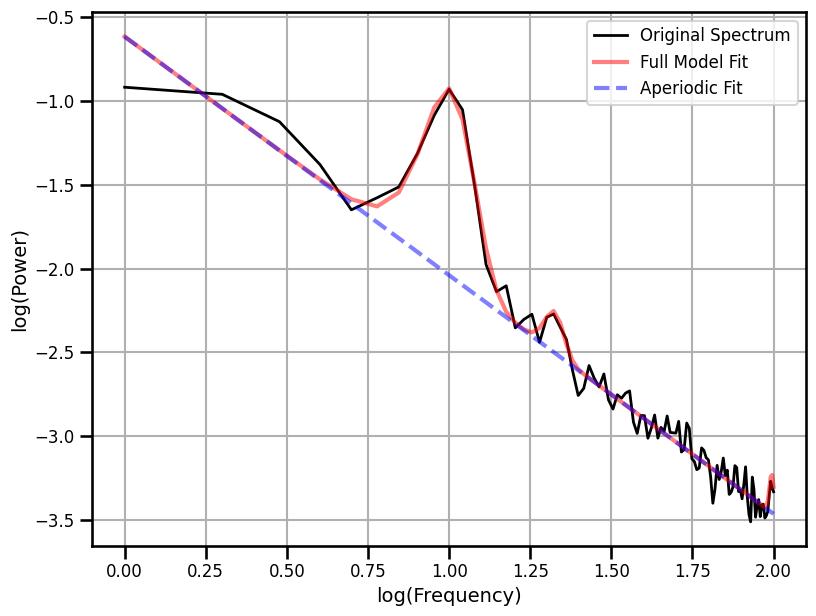

In [26]:
# Visualize 
fm.plot(**PSD_PLT_KWARGS,
        save_fig=SAVE_FIG, file_name='sp_example_bw' + EXT, file_path=FIGPATH)

In [27]:
# Check the calculated value against ground truth
print('Measured Exponent:\t {:1.4f}'.format(fm.get_params('aperiodic', 'exponent')))
print('Expected Exponent:\t {:1.4f}'.format(EXP))

Measured Exponent:	 1.4229
Expected Exponent:	 -1.5000


## SPECPARAM Simulation Tests

### Simulations: Aperiodic Variations

#### Aperiodic Exponent

In [28]:
# Run simulations calculating specparam estimation across exponents
sp_sims_exp, sp_sims_exp_var = run_sims(\
    sim_powerlaw, SIM_PARAMS_AP, specparam, SPECPARAM_PARAMS, 'update_exp', EXPS, N_SIMS)

#### Aperiodic Exponent (combined signal)

In [29]:
# Run simulations calculating specparam exponent across exponents, with an oscillation
sp_sims_comb, sp_sims_comb_var = run_sims(\
    sim_combined, SIM_PARAMS_COMB, specparam, SPECPARAM_PARAMS, 'update_comb_exp', EXPS, N_SIMS)

#### Visualize Results

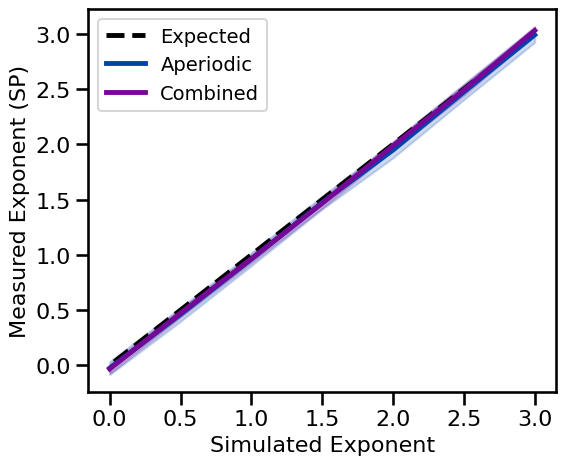

In [30]:
# Plot specparam exponent estimation across exponents, both with and without oscillation
plot_ap_sims(sp_sims_exp, sp_sims_exp_var, sp_sims_comb, sp_sims_comb_var, 
             'Measured Exponent (SP)', expected=np.abs(EXPS),
             save_fig=SAVE_FIG, file_name='sp_ap' + EXT, file_path=FIGPATH)

### Simulations: Periodic Variations

#### Oscillation Frequency

In [31]:
# Run simulations calculating specparam exponent across oscillation frequencies
sp_sims_freq, sp_sims_freq_var = run_sims(\
    sim_combined, SIM_PARAMS_COMB, specparam, SPECPARAM_PARAMS, 'update_freq', FREQS, N_SIMS)

#### Oscillation Power

In [32]:
# Run simulations calculating specparam exponent across oscillation power
sp_sims_pow, sp_sims_pow_var = run_sims(\
    sim_combined, SIM_PARAMS_COMB, specparam, SPECPARAM_PARAMS, 'update_pow', POWERS, N_SIMS)

#### Visualize Results

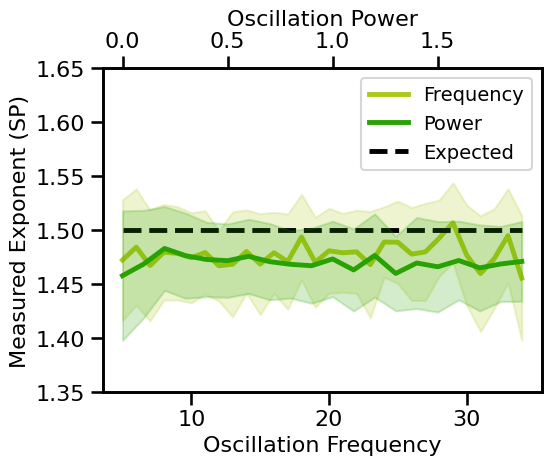

In [33]:
# Plot effect of oscillation variation on DFA exponent
plot_pe_sims(sp_sims_freq, sp_sims_freq_var, sp_sims_pow, sp_sims_pow_var,
             'Measured Exponent (SP)', expected=[1.5]*len(FREQS), ylim=[1.35, 1.65],
             save_fig=SAVE_FIG, file_name='sp_pe' + EXT, file_path=FIGPATH)

## Simulations: Knee Variations

In [34]:
# Run simulations calculating specparam exponent across different timescales
sp_sims_knee_lin, sp_sims_knee_lin_var = run_sims(\
    sim_synaptic_current, SIM_PARAMS_KNEE, specparam, SPECPARAM_PARAMS, 'update_knee', KNEES, N_SIMS)

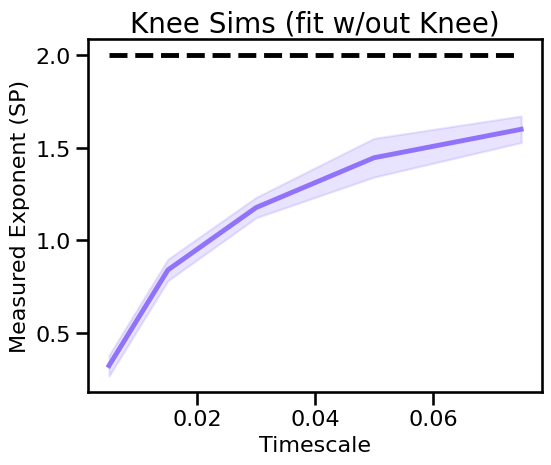

In [35]:
# Plot the estimated exponent across different timescales (estimated without a knee)
plot_sims(KNEES, sp_sims_knee_lin, sp_sims_knee_lin_var, 
          xlabel='Timescale', ylabel='Measured Exponent (SP)', color=COLORS['KN'],
          expected=[2.0] * len(KNEES), title='Knee Sims (fit w/out Knee)',
          save_fig=SAVE_FIG, file_name='sp_knee_lin' + EXT, file_path=FIGPATH)

In [36]:
# Run simulations calculating specparam exponent across different timescales
sp_sims_knee, sp_sims_knee_var = run_sims(\
    sim_synaptic_current, SIM_PARAMS_KNEE, specparam, SPECPARAM_PARAMS_KNEE, 'update_knee', KNEES, N_SIMS)

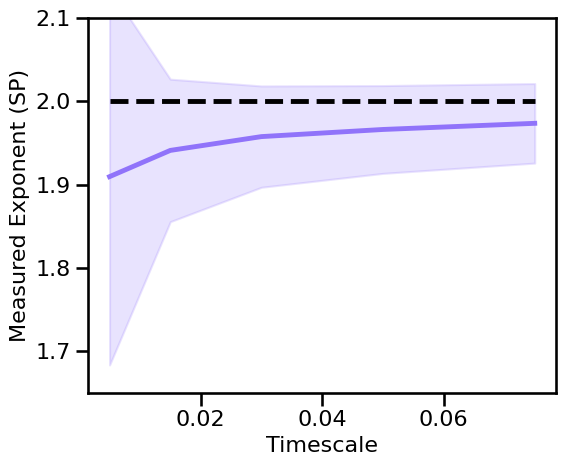

In [37]:
# Plot the estimated exponent across different timescales (estimated with a knee)
plot_sims(KNEES, sp_sims_knee, sp_sims_knee_var, color=COLORS['KN'],
          expected=[2.0] * len(KNEES), ylim=[1.65, 2.1],
          xlabel='Timescale', ylabel='Measured Exponent (SP)',
          save_fig=SAVE_FIG, file_name='sp_knee' + EXT, file_path=FIGPATH)

## Simulations: Bandwidth Variations

In [38]:
# Simulate and apply specparam to simulations across peak bandwidths
# sp_sims_bw, sp_sims_bw_var = run_sims(\
#     sim_combined_peak, SIM_PARAMS_PEAK, specparam, SPECPARAM_PARAMS, 'update_peak_bw', BWS, N_SIMS)

In [39]:
# Run simulations calculating specparam exponent estimate across peak bandwidth (sims from file)
sp_sims_bw, sp_sims_bw_var = run_sims_load(\
    SIMPATH / 'ts_sims_comb_bw', specparam, SPECPARAM_PARAMS)

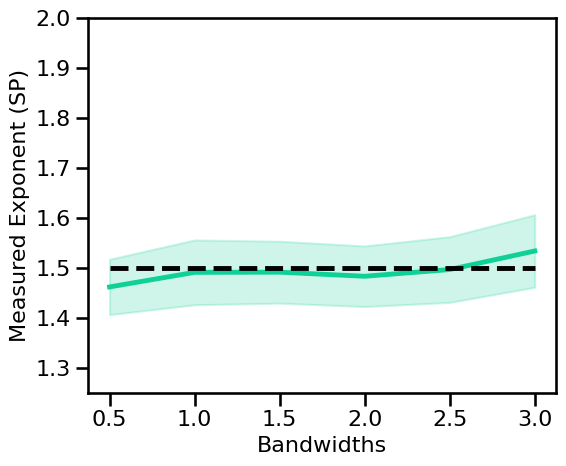

In [40]:
# Plot the estimated exponent across peak bandwidths
plot_sims(BWS, sp_sims_bw, sp_sims_bw_var, color=COLORS['BW'],
          expected=[-EXP] * len(BWS), ylim=[1.25, 2.0],
          xlabel='Bandwidths', ylabel='Measured Exponent (SP)',
          save_fig=SAVE_FIG, file_name='sp_bw' + EXT, file_path=FIGPATH)

## Conclusions

Overall, we can see the following patterns in these simulations:
- Spectral parameterization is a robust estimator of the aperiodic exponent across multiple simulation parameters